<a href="https://colab.research.google.com/github/TTD-JPO/TDD-project/blob/jedi3/Main_TweetDisasterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Twitter Disaster Detection

<center>

# Load Libs & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, time

In [2]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [3]:
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, plot_confusion_matrix

from sklearn.naive_bayes import CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
import re
import string
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[Link to data (csv) @google drive](https://drive.google.com/file/d/1QPragNh_wYQVsXQvds8sqjDMfzARD638/view?usp=sharing)


In [5]:
url = 'https://raw.githubusercontent.com/TTD-JPO/TDD-project/main/disaster_tweets.csv'
disaster_tweets = pd.read_csv(url, encoding='latin-1')

# Helper function

In [6]:
def clean_text(text):
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")

  digi_punct = "[^a-zA-Z' ]"
  text = re.sub(digi_punct, " ", text)
  text = " ".join(text.split())
  text = text.lower()

  return text

def my_df_text_mining(df, col):
  lemmatizer = WordNetLemmatizer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([lemmatizer.lemmatize(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)

################################

def my_df_spacy_locgpe(df, col):  
  df["loc_gpe"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='LOC') | (ent.label_ =='GPE'))]) )
  return df

def my_df_spacy_date_time(df, col):
  df["date_time"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='DATE') | (ent.label_ =='TIME'))]) )
  return df

def my_df_spacy_fac(df, col):
  df["FAC"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if (ent.label_ =='FAC') ]) )
  return df
################################

def spcy_test(text):
  displacy.render(nlp(clean_text(text)), style='ent', jupyter=True)

################################

def corpus_func(series):
    '''create a text block (corpus) from a series'''
    return " #### ".join(text for text in series)

def corpus_list(corpus):
    '''create a list from text block (corpus)'''
    corpus_list = lambda x: x.split(' #### ')

In [75]:
#jedi's helpers
#
def my_fit_cm(df, pipe, feature_list, target):
  # includes train test split, model fit, and
  # plots confusion matrix
  #
  ################ currently no feature_list, but only ONE feature ?
  #
  ################

  X_train, X_test,\
  y_train, y_test =\
  train_test_split(df[feature_list],
                    df[target],
                    test_size=0.2,
                    random_state=314159,
                    stratify=df[target])

  #display( cross_val_score(pipe, X_train, y_train).mean() )

  pipe.fit(X_train, y_train)
  plot_confusion_matrix(pipe, X_train, y_train, values_format="0.3f", normalize='true', cmap="RdYlGn")
  plt.title(f"best accuracy: { accuracy_score(y_train, pipe.predict(X_train)):0.3f}")

  plot_confusion_matrix(pipe, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
  plt.title(f"best accuracy: { accuracy_score(y_test, pipe.predict(X_test)):0.3f}")
  plt.show()
  # end


In [8]:
#PW
# new helper of PW

In [9]:
#OCF


## Evaluate data

In [10]:
disaster_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [11]:
print( "absolute number of disaster indicated messages:", disaster_tweets.target.sum() )
print( f"relative number of disaster indicated messages: {disaster_tweets.target.sum() / disaster_tweets.shape[0] :0.3f}" )

absolute number of disaster indicated messages: 3271
relative number of disaster indicated messages: 0.430


In [12]:
keys      = list(disaster_tweets.keyword.unique() )
locations = list(disaster_tweets.location.unique() )
print(f'len_keys: {len(keys)}\tlen_locations: {len(locations)}')

len_keys: 222	len_locations: 3342


In [13]:
disaster_tweets.groupby('keyword').target.count().sort_values(ascending=False)

keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: target, Length: 221, dtype: int64

In [14]:
disaster_tweets.groupby('location').target.count().sort_values(ascending=False)

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Name: target, Length: 3341, dtype: int64

In [15]:
display( f"relative number of keyword   messages: {disaster_tweets.keyword.nunique()  / disaster_tweets.shape[0] :0.3f}" )
display( f"relative number of location  messages: {disaster_tweets.location.nunique() / disaster_tweets.shape[0] :0.3f}" )

'relative number of keyword   messages: 0.029'

'relative number of location  messages: 0.439'

In [16]:
### we might do these steps later after having processed the text :)
#dt = disaster_tweets.copy()

## Visualization of data (of)

In [17]:
df = disaster_tweets

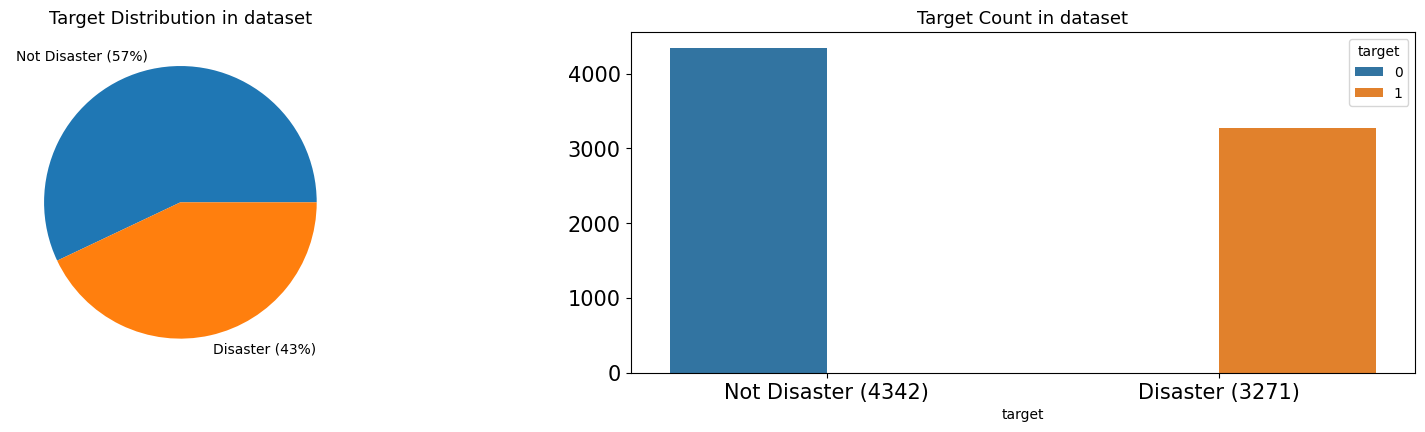

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in dataset', fontsize=13)
axes[1].set_title('Target Count in dataset', fontsize=13)

plt.show()

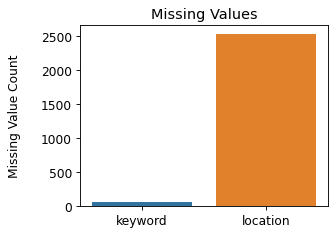

In [19]:
missing_cols = ['keyword', 'location']

plt.figure(figsize=(4, 3), dpi=80)

sns.barplot(x=disaster_tweets[missing_cols].isna().sum().index, y=disaster_tweets[missing_cols].isna().sum().values)

plt.ylabel('Missing Value Count', size=11, labelpad=18)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)

plt.title('Missing Values', fontsize=13)

plt.show()

# Cleaning of data 
- df deaster tweets - 'dtt_clean'

In [20]:
dtt_clean = disaster_tweets.copy()

In [21]:
dtt_clean = my_df_text_mining(dtt_clean, 'text')

In [22]:
dtt_clean.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked 'shelter place' notified office...,1


### clean NaN

In [23]:
missing_cols = ['keyword', 'location']
for col in  missing_cols:
    dtt_clean[col] = dtt_clean[col].fillna(f'no_{col}')

In [24]:
dtt_clean.head(2)

,id,keyword,location,text,target
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1


# Analizing tweet < text >
- NLP keyword, localization 

### trail ... (pw)


In [25]:
#Regex:
dtt_clean['keyword_re'] = dtt_clean.keyword.apply(lambda text: re.sub("%20"," ", text))  # leerzeichen !!!

In [26]:
# analog to goupby in Evaluate data (but after clean keyword)
# make a count for the keyword list

### zu den libaries wenn codezelle bleiben soll
from collections import Counter


key_count = sorted(Counter(list(dtt_clean['keyword_re'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
print(key_count[0:20])

[('no_keyword', 61), ('fatalities', 45), ('deluge', 42), ('armageddon', 42), ('sinking', 41), ('harm', 41), ('damage', 41), ('body bags', 41), ('windstorm', 40), ('twister', 40), ('siren', 40), ('outbreak', 40), ('fear', 40), ('evacuate', 40), ('collided', 40), ('wrecked', 39), ('wreckage', 39), ('whirlwind', 39), ('weapons', 39), ('weapon', 39)]


In [27]:
'''
#zu überarbeiten
from nltk.stem import SnowballStemmer

sb_stemmer = SnowballStemmer('english')
dtt_clean['keyword_stem']= dtt_clean["keyword_re"].apply(lambda keyword_re: " ".join([sb_stemmer.stem(word) for word in keyword_re]))
'''

'\n#zu überarbeiten\nfrom nltk.stem import SnowballStemmer\n\nsb_stemmer = SnowballStemmer(\'english\')\ndtt_clean[\'keyword_stem\']= dtt_clean["keyword_re"].apply(lambda keyword_re: " ".join([sb_stemmer.stem(word) for word in keyword_re]))\n'

In [28]:
corpus_keys = corpus_func(dtt_clean['keyword_re'])

In [29]:
keyword_low=[x.lower() for x in dtt_clean['keyword_re']]

In [30]:
dtt_clean['keyword_low'] = keyword_low

In [31]:
#from nltk.stem import PorterStemmer
#stemmer = PorterStemmer()
#
#stem_tok ={}
#for w in tokens_low: 
#    stem_tok[w] = stemmer.stem(w)
#
#stem_tok 

In [32]:
#dtt_clean['keyword_stem']= dtt_clean["keyword_re"].apply(lambda keyword_re: " ".join([stemmer.stem(word) for word in keyword_re]))
#dtt_clean['keyword_stem']

In [33]:
#lemmatizer.lemmatize('going', wordnet.NOUN)

end_-petra

In [34]:
len(keys), len(locations)

(222, 3342)

In [35]:
dtt_clean

,id,keyword,location,text,target,keyword_re,keyword_low
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1,no_keyword,no_keyword
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1,no_keyword,no_keyword
2,5,no_keyword,no_location,resident asked 'shelter place' notified office...,1,no_keyword,no_keyword
3,6,no_keyword,no_location,people receive wildfire evacuation order calif...,1,no_keyword,no_keyword
4,7,no_keyword,no_location,got sent photo ruby alaska smoke wildfire pour...,1,no_keyword,no_keyword
...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,two giant crane holding bridge collapse nearby...,1,no_keyword,no_keyword
7609,10870,no_keyword,no_location,aria ahrary thetawniest control wild fire cali...,1,no_keyword,no_keyword
7610,10871,no_keyword,no_location,utc km volcano hawaii http co zdtoyd ebj,1,no_keyword,no_keyword
7611,10872,no_keyword,no_location,police investigating e bike collided car littl...,1,no_keyword,no_keyword


In [36]:
no_target_ = dtt_clean[ dtt_clean.target == 0]
target_    = dtt_clean[ dtt_clean.target == 1]

-- (PW)

## jedi playground

In [37]:
test_text = "Barbados #Bridgetown JAMAICA Â\x89Ã\x9bÃ\x92 Two cars set ablaze: SANTA CRUZ Â\x89Ã\x9bÃ\x93 Head of the St Elizabeth Police Superintende"
#test_text = 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding'
#test_text = "#stlouis #caraccidentlawyer Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 https://t.co/S2kXVM0cBA Car Accident teeÂ\x89Ã\x9b_"
spcy_test(test_text)


In [38]:
test_df = disaster_tweets[40:60]
#list(test_df.text)

In [ ]:
%time df1 = my_df_spacy_locgpe(test_df.copy(), 'text')
#df1

In [40]:
#df2 = my_df_spacy_fac   (df1.copy(), 'text')
#df2

# Evaluationg Basic modeling

In [41]:
### ready for DELETE

df    = disaster_tweets.copy()

In [42]:
#tfidf_v = TfidfVectorizer(ngram_range=(1, 2))
#tfidf_bow = tfidf_v.fit_transform(df["_lemmatized"])   # FIT and transform to learn
### ??? wo wird das denn weiterverwendet ???

In [43]:
#tfidf_v.transform(no_df['_lemmatized'])  # only transformation!!!

## Train-Test-Split

In [44]:
### ready for DELETE

X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])

##pipline Tfidf, MultinomialNB

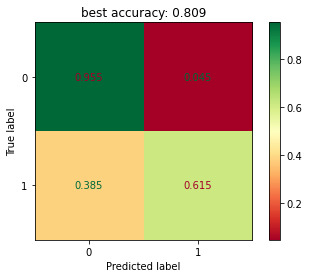

In [45]:
### ready for DELETE

#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

#display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()

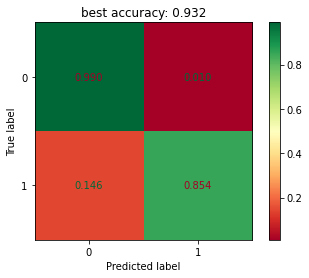

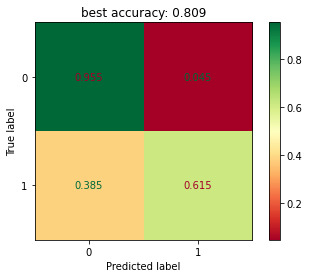

CPU times: user 1.45 s, sys: 31.6 ms, total: 1.48 s
Wall time: 1.5 s


In [76]:
################# NEW #################
dt = disaster_tweets.copy() # original data set, no postprocessin
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB()) #### naive bayes 
%time my_fit_cm(df, pipeMNB, "text", "target")

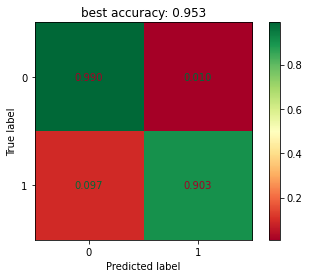

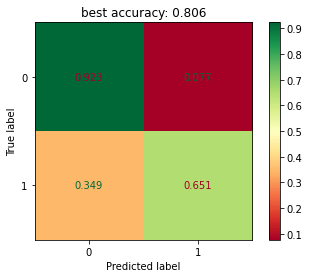

CPU times: user 1.17 s, sys: 13 ms, total: 1.18 s
Wall time: 1.19 s


In [47]:
df = my_df_text_mining(disaster_tweets.copy(), 'text')  # minor postprocessing: remove numbers and #,@, .... Special characters
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB()) #### naive bayes 
%time my_fit_cm(df, pipeMNB, "text", "target")

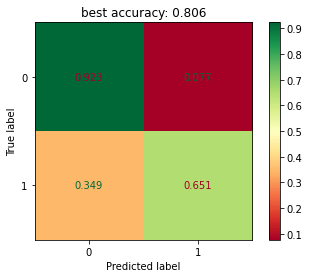

In [48]:
### ready for DELETE

#df = disaster_tweets.copy()
df = my_df_text_mining(disaster_tweets.copy(), 'text')
#### filtering numvers and special characters
#### copy for trials

X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])


#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

#display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()

In [49]:
# marginal change: (1,1) improved, but (0,0) declined ... :( S

# Evaluation extended Modeling (weitere Spalten)

In [50]:
### AP: show result for one text line, or many example line

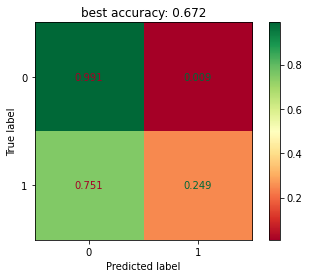

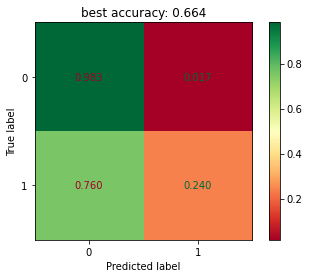

CPU times: user 421 ms, sys: 9.99 ms, total: 431 ms
Wall time: 436 ms


In [61]:
df = my_df_spacy_locgpe(disaster_tweets.copy(), 'text')

pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB()) #### naive bayes 
%time my_fit_cm(df, pipeMNB, 'loc_gpe', "target")
# poor result: acc= 0.664

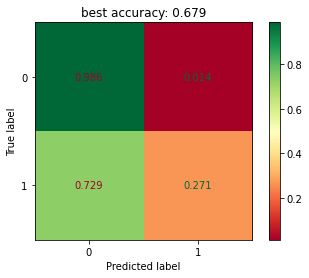

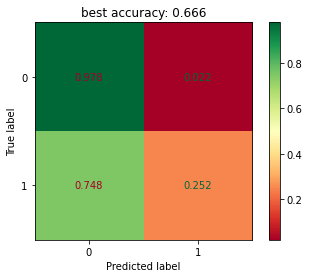

CPU times: user 492 ms, sys: 6.97 ms, total: 499 ms
Wall time: 510 ms


In [62]:
# next try
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LogisticRegression()) 
%time my_fit_cm(df, pipe, 'loc_gpe', "target")

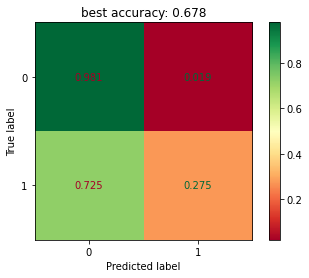

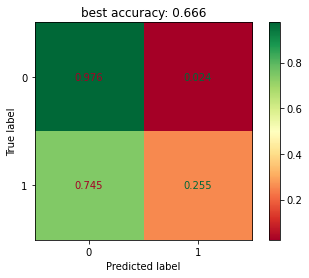

CPU times: user 454 ms, sys: 8.95 ms, total: 463 ms
Wall time: 466 ms


In [63]:
# next try
pipe = make_pipeline(CountVectorizer(), LogisticRegression()) 
%time my_fit_cm(df, pipe, 'loc_gpe', "target")

In [ ]:
######## ERRORS ####### will keine stings :///// #######
df_ = my_df_spacy_locgpe(disaster_tweets.copy(), 'text')
df  = my_df_spacy_date_time(df_ , 'text')
feature_list = ['loc_gpe','date_time']
target = "target"

# next try
pipe = make_pipeline( LogisticRegression() ) 
%time my_fit_cm(df, pipe, feature_list, "target")

In [85]:
# some counts
df = disaster_tweets.copy()
df['_#_'] = df['text'].apply(lambda x: str(x).count('#') )
df['_@_'] = df['text'].apply(lambda x: str(x).count('@') )
df['_/_'] = df['text'].apply(lambda x: str(x).count('/') )
df

,id,keyword,location,text,target,_#_,_@_,_/_
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2,0,0
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0,0,3
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0,0,3
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,0,0,0


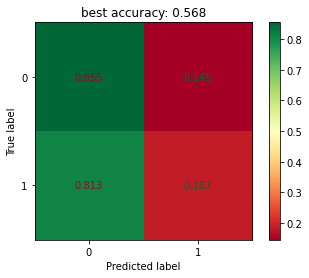

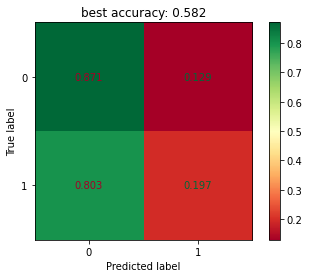

CPU times: user 502 ms, sys: 159 ms, total: 661 ms
Wall time: 469 ms


In [72]:
feature_list = ['_#_','_@_','_/_']
# next try
pipe = make_pipeline( LogisticRegression() ) 
%time my_fit_cm(df, pipe, feature_list, "target")

# Final Model

In [52]:
# Performance